###### Using support vector machines (SVMs) to build `a spam classifier`

In [1]:
import numpy  as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import scipy
import scipy.optimize as opt
import scipy.io as sio
from scipy.io import loadmat

%matplotlib inline

![Kernel Machine](Figures/Kernel_Machine.png?raw=true "Kernel Machine")

SVMs help us look at our training examples and `learn a way to map them to a high-dimensional space` so that we can `separate different categories with boundaries` that are as wide as possible (as in the image above). When a new example comes along, we can map it to that space and categorize it based on which side of the boundaries it falls on. 

This mapping is possible due to a [_kernel_](https://en.wikipedia.org/wiki/Kernel_method) function. This is the function that maps the examples into a high-dimensional space. Use of kernel functions are often called kernel tricks because we don't need to know the exact mapping of the examples into that space (which can be expensive to compute), but rather only the _similarity_ between those mappings (which can be cheaper to compute).

Even if this is all a bit fuzzy, SVMs are important to know and interesting to look at because they have been a [popular](https://www.quora.com/Why-did-SVM-become-more-popular-than-Logistic-Regression) [black-box](https://datascience.stackexchange.com/questions/711/are-support-vector-machines-still-considered-state-of-the-art-in-their-niche) [choice](https://www.researchgate.net/post/Can_we_say_that_SVM_is_the_best_classifier_to_date14) for machine learning practitioners.

# Support Vector Machines

Using support vector machines (SVMs) with various example 2D datasets

## Linearly separable data

We will begin by with a 2D example dataset which can be separated by a linear boundary.

###### load data

In [2]:
path = "dataset/ex6data1.mat"
data = sio.loadmat(path)

X_ori = data['X']
y_ori = data['y'].reshape((-1,))

print("X_ori.shape", X_ori.shape)
print("y_ori.shape", y_ori.shape)

ori_data = np.c_[X_ori, y_ori]

X_ori.shape (51, 2)
y_ori.shape (51,)


###### plot orignial data

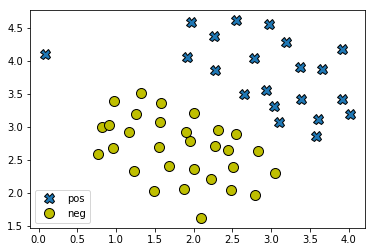

In [3]:
def plot_ori_data(data, label_pos, label_neg, axes=None):
    if axes == None:
        axes = plt.gca()

    pos = np.array([ data[i] for i in range(len(data)) if data[i,-1:] == 1 ])
    neg = np.array([ data[i] for i in range(len(data)) if data[i,-1:] == 0 ])
    
    axes.plot(np.array(pos[:,0]), np.array(pos[:,1]), 'X', mew=1, ms=10, mec='k', label=label_pos)
    axes.plot(np.array(neg[:,0]), np.array(neg[:,1]), 'o', mew=1, mfc='y', ms=10, mec='k', label=label_neg)   
    axes.legend(loc=3)

plot_ori_data(ori_data, 'pos', 'neg')

In this dataset, the positions of the positive examples (indicated with `x`) and the negative examples (indicated with `o`) suggest a natural separation indicated by the gap. 

However, notice that there is an `outlier positive example` `x` on the far left at about (0.1, 4.1). 

As part of this exercise, you will also see how this outlier affects the SVM decision boundary.

In this part of the exercise, you will try `using different values of the` $C$ `parameter with SVMs`. Informally, the $C$ parameter is `a positive value that controls the penalty for misclassified training examples`. A large $C$ parameter tells the SVM to try to classify all the examples correctly. $C$ plays a role similar to $1/\lambda$, where $\lambda$ is the regularization parameter that we were using previously for logistic regression.

<div class="alert alert-block alert-warning">
**Implementation Note:** Most SVM software packages (including the function `utils.svmTrain`) automatically add the extra feature $x_0$ = 1 for you and automatically take care of learning the intercept term $\theta_0$. So when passing your training data to the SVM software, there is no need to add this extra feature $x_0 = 1$ yourself. In particular, in python your code should be working with training examples $x \in \mathcal{R}^n$ (rather than $x \in \mathcal{R}^{n+1}$); for example, in the first example dataset $x \in \mathcal{R}^2$.
</div>

### learning $\theta$ by `sklearn.svm`
[``sklearn.svm.SCV()``](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
[``sklearn.svm.SVR()``](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)
[``sklearn.svm.LinearSVC()``](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)
[``sklearn.svm.LinearSVR()``](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html)

In [4]:
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR

In [5]:
def sk_svm_svc(X, y, c=1, K='linear', G=1):
    if K == 'linear':
        model = SVC(C=c, kernel=K)
    elif K == 'rbf':
        model = SVC(C=c, kernel=K, gamma=G)
    
    model.fit(X, y)
    
    return model

In [6]:
clf_1 = sk_svm_svc(X_ori, y_ori)
clf_1.score(X_ori, y_ori)

0.9803921568627451

In [7]:
clf_100 = sk_svm_svc(X_ori, y_ori, c=100)
clf_100.score(X_ori, y_ori)

1.0

In [8]:
clf_1.support_vectors_

array([[1.5841  , 3.3575  ],
       [2.0103  , 3.2039  ],
       [2.3099  , 2.9584  ],
       [2.8283  , 2.6309  ],
       [1.3191  , 3.5109  ],
       [2.5403  , 2.8867  ],
       [3.5772  , 2.856   ],
       [3.1048  , 3.0709  ],
       [1.9182  , 4.0534  ],
       [2.6555  , 3.5008  ],
       [3.0357  , 3.3165  ],
       [0.086405, 4.1045  ]])

### Plot decision boundary

In [9]:
def calc_normal_vector(model, X, axes=None):
    w = model.coef_[0]
    b = model.intercept_[0]
    
    x1 = X[:,0]
    X1_range = np.linspace(x1.min(), x1.max(), 100)
    
    X2_range = -(w[0] * X1_range + b) / w[1]
    
    if axes == None:
        axes = plt.gca()
    
    axes.plot(X1_range, X2_range)
    
    sv = model.support_vectors_
    axes.plot(sv[:, 0], sv[:, 1], 'ro', markersize=15, mec='r', mew=2, mfc='none')

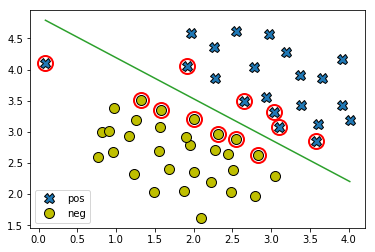

In [10]:
plot_ori_data(ori_data, 'pos', 'neg')
calc_normal_vector(clf_1, X_ori, axes=plt.gca())

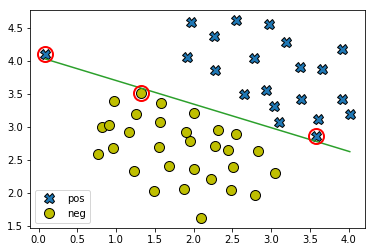

In [11]:
plot_ori_data(ori_data, 'pos', 'neg')
calc_normal_vector(clf_100, X_ori, axes=plt.gca())

In [12]:
def plot_decision_boundary(data, model, axes=None):
    if axes == None:
        axes = plt.gca()
    
    gap = 0.3
    X1_min, X1_max = data[:,0].min()-gap, data[:,0].max()+gap
    X2_min, X2_max = data[:,1].min()-gap, data[:,1].max()+gap
    
    xx1, xx2 = np.meshgrid(np.linspace(X1_min, X1_max), np.linspace(X2_min, X2_max))
    Countour_X = np.c_[xx1.ravel().reshape(-1,1), xx2.ravel().reshape(-1,1)]
    hyp = model.predict(Countour_X).reshape(xx1.shape)
    axes.contour(xx1, xx2, hyp, 1, linewidths=1, colors='b')
    
    sv = model.support_vectors_
    axes.plot(sv[:, 0], sv[:, 1], 'ro', markersize=15, mec='r', mew=2, mfc='none')

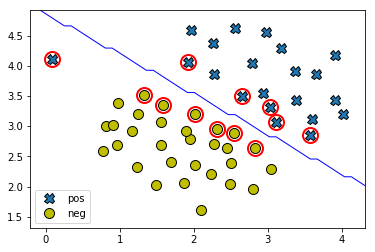

In [13]:
plot_ori_data(ori_data, 'pos', 'neg')
plot_decision_boundary(ori_data, clf_1, axes=plt.gca())

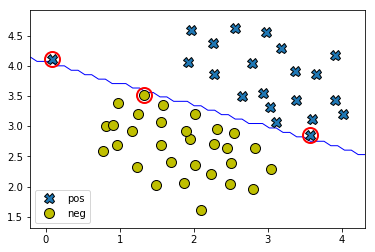

In [14]:
plot_ori_data(ori_data, 'pos', 'neg')
plot_decision_boundary(ori_data, clf_100, axes=plt.gca())

In [15]:
def plot_decision_boundary_by_color(X, y, c=1.0):
    model = LinearSVC(C=c, loss='hinge')
    model.fit(X, y)
    
    y_pred = model.decision_function(X)
    
    plt.scatter(X[:,0], X[:,1], s=50, c=y_pred, cmap='RdBu')

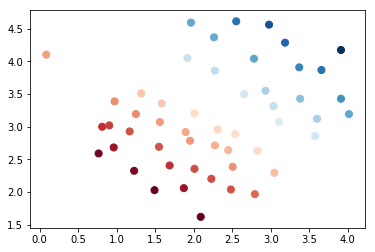

In [16]:
plot_decision_boundary_by_color(X_ori, y_ori, 1)

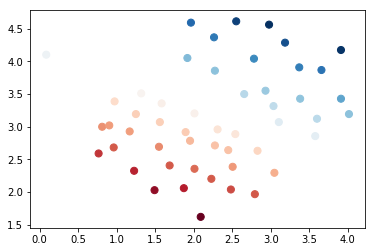

In [17]:
plot_decision_boundary_by_color(X_ori, y_ori, 100)

## SVM with Gaussian Kernel

In particular, you will be using SVMs with Gaussian kernels on datasets that are `not linearly separable`.

### Gaussian Kernel

You can think of `the Gaussian kernel` as `a similarity function` that `measures the “distance” between a pair of examples`, ($x^{(i)}$, $x^{(j)}$). 

The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples are further apart.

The Gaussian kernel function is defined as:

$$ K_{\text{gaussian}} \left( x^{(i)}, x^{(j)} \right) = \exp \left( - \frac{\left\lvert\left\lvert x^{(i)} - x^{(j)}\right\lvert\right\lvert^2}{2\sigma^2} \right) = \exp \left( -\frac{\sum_{k=1}^n \left( x_k^{(i)} - x_k^{(j)}\right)^2}{2\sigma^2} \right)$$
<a id="gaussianKernel"></a>

In [18]:
def gaussian_kernel(x1, x2, sigma):
    sim = np.exp(-np.power(np.linalg.norm(x1 - x2), 2) / (2 * sigma * sigma))
    
    return sim

In [19]:
x1 = np.array([1, 2, 1])
x2 = np.array([0, 4, -1])
sigma = 2

sim = gaussian_kernel(x1, x2, sigma)
print(sim)
print('Gaussian Kernel between\n\tx1 = [1, 2, 1]\n\tx2 = [0, 4, -1]\n\tsigma = %0.2f:'
      '\n\tsim = %f <<\n(for sigma = 2, this value should be about 0.324652)\n' % (sigma, sim))

0.32465246735834974
Gaussian Kernel between
	x1 = [1, 2, 1]
	x2 = [0, 4, -1]
	sigma = 2.00:
	sim = 0.324652 <<
(for sigma = 2, this value should be about 0.324652)



### non-linearly separable data

In [20]:
path = "dataset/ex6data2.mat"
data = sio.loadmat(path)

X_ori = data['X']
y_ori = data['y'].reshape((-1,))

print("X_ori.shape", X_ori.shape)
print("y_ori.shape", y_ori.shape)

ori_data = np.c_[X_ori, y_ori]

X_ori.shape (863, 2)
y_ori.shape (863,)


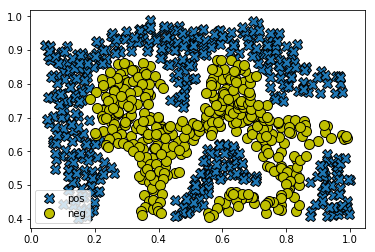

In [21]:
plot_ori_data(ori_data, 'pos', 'neg')

From the figure, you can obserse that there is no linear decision boundary that separates the positive and negative examples for this dataset. 

However, `by using the Gaussian kernel with the SVM`, you will be able to `learn a non-linear decision boundary` that can perform reasonably well for the dataset. 

这里需要注意一下，`高斯核函数的参数` $\sigma$ & `RBF核函数`的gamma
> + $$ gamma = \frac{1} {2 * \sigma^{{2}}}$$
> + http://scikit-learn.org/stable/modules/svm.html#svm-kernels

In [22]:
clf_gaussion_1 = sk_svm_svc(X_ori, y_ori, c=1, K='rbf', G=50)
clf_gaussion_1.score(X_ori, y_ori)

0.9895712630359212

In [23]:
clf_gaussion_100 = sk_svm_svc(X_ori, y_ori, c=100, K='rbf', G=50)
clf_gaussion_100.score(X_ori, y_ori)

0.9976825028968713

### plot no linear decision boundary

In [24]:
def plot_decision_boundary(data, model, axes=None):
    if axes == None:
        axes = plt.gca()
    
    gap = 0.1
    X1_min, X1_max = data[:,0].min()-gap, data[:,0].max()+gap
    X2_min, X2_max = data[:,1].min()-gap, data[:,1].max()+gap
    
    xx1, xx2 = np.meshgrid(np.linspace(X1_min, X1_max), np.linspace(X2_min, X2_max))
    Countour_X = np.c_[xx1.ravel().reshape(-1,1), xx2.ravel().reshape(-1,1)]
    hyp = model.predict(Countour_X).reshape(xx1.shape)
    axes.contour(xx1, xx2, hyp, 1, linewidths=3, colors='r')

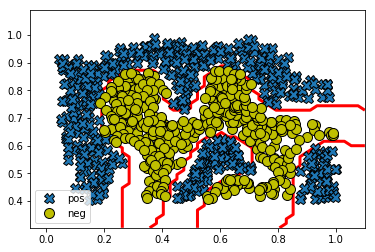

In [25]:
plot_ori_data(ori_data, 'pos', 'neg')
plot_decision_boundary(ori_data, clf_gaussion_1, axes=plt.gca())

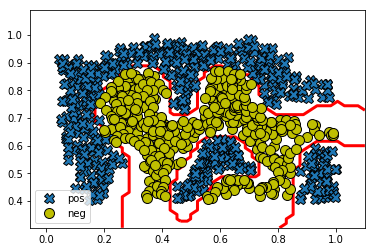

In [26]:
plot_ori_data(ori_data, 'pos', 'neg')
plot_decision_boundary(ori_data, clf_gaussion_100, axes=plt.gca())

## Search for the best parameters

In [27]:
path = "dataset/ex6data3.mat"
data = sio.loadmat(path)

X_train = data['X']
y_train = data['y'].reshape((-1,))

X_cv = data['Xval']
y_cv = data['yval']

print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)

print("X_cv.shape", X_cv.shape)
print("y_cv.shape", y_cv.shape)

ori_data = np.c_[X_train, y_train]

X_train.shape (211, 2)
y_train.shape (211,)
X_cv.shape (200, 2)
y_cv.shape (200, 1)


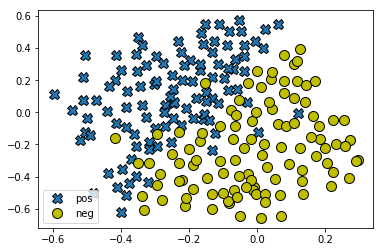

In [28]:
plot_ori_data(ori_data, 'pos', 'neg')

Your task is to use the cross validation set `Xval`, `yval` to determine the best $C$ and $\sigma$ parameter to use.

For both $C$ and $\sigma$, we suggest trying values in multiplicative steps (e.g., 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30).

Note that you should try all possible pairs of values for $C$ and $\sigma$ (e.g., $C = 0.3$ and $\sigma = 0.1$). For example, if you try each of the 8 values listed above for $C$ and for $\sigma^2$, you would end up training and evaluating (on the cross validation set) a total of $8^2 = 64$ different models. 

<div class="alert alert-block alert-warning">
**Implementation Tip:** When implementing cross validation to select the best $C$ and $\sigma$ parameter to use, you need to evaluate the error on the cross validation set. Recall that for classification, the error is defined as the fraction of the cross validation examples that were classified incorrectly. In `numpy`, you can compute this error using `np.mean(predictions != yval)`, where `predictions` is a vector containing all the predictions from the SVM, and `yval` are the true labels from the cross validation set. You can use the `utils.svmPredict` function to generate the predictions for the cross validation set.
</div>
<a id="dataset3Params"></a>

In [29]:
candidate = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
combination = [(C, gamma) for C in candidate for gamma in candidate]

In [30]:
search = []

for C, gamma in combination:
    model = sk_svm_svc(X_train, y_train, c=C, K='rbf', G=gamma)
    search.append(model.score(X_cv, y_cv))

In [31]:
best_score = search[np.argmax(search)]
best_param = combination[np.argmax(search)]

print(">> best_score :", best_score)
print("   best param :")
print("       -------- C :", best_param[0])
print("       ---- Gamma :", best_param[1])

>> best_score : 0.965
   best param :
       -------- C : 0.3
       ---- Gamma : 100


In [32]:
from sklearn.metrics import classification_report
best_svc = sk_svm_svc(X_train, y_train, c=best_param[0], K='rbf', G=best_param[1])
ypred = best_svc.predict(X_cv)
print(classification_report(y_cv, ypred))

             precision    recall  f1-score   support

          0       0.97      0.96      0.97       113
          1       0.95      0.97      0.96        87

avg / total       0.97      0.96      0.97       200



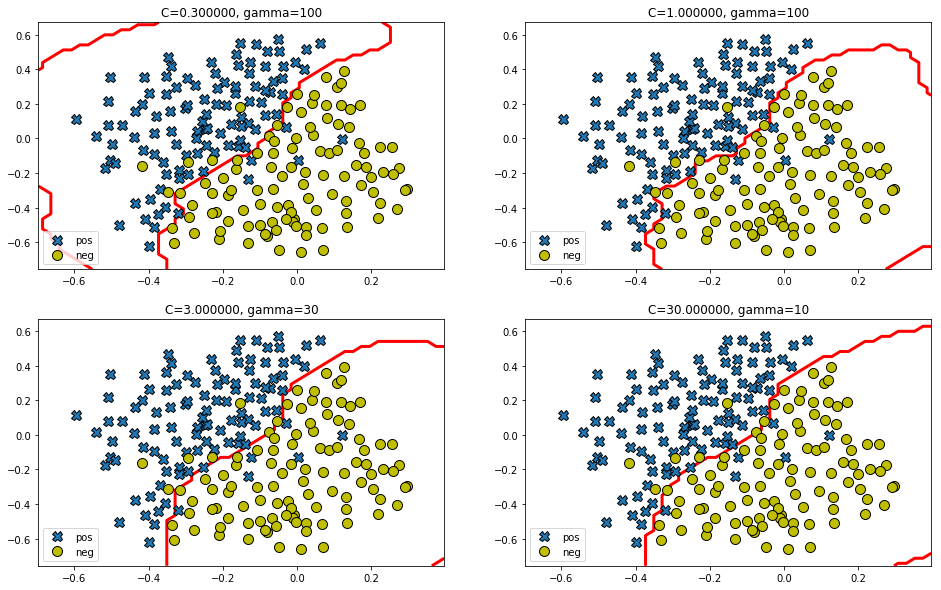

In [33]:
best = np.where(np.array(search) == 0.965)

fig, axes = plt.subplots(2, 2, figsize=((16, 10)))
for i in range(4):
    axes_i = axes.flatten()[i]
    
    ind = best[0][i]
    C = combination[ind][0]
    gamma = combination[ind][1]
    
    model = sk_svm_svc(X_train, y_train, c=C, K='rbf', G=gamma)
    plot_ori_data(ori_data, 'pos', 'neg', axes_i)
    plot_decision_boundary(ori_data, model, axes_i)
    axes_i.set_title("C=%f, gamma=%d" % (combination[ind][0], combination[ind][1]))

###### sklearn.model_selection.GridSearchCV
[``sklearn.model_selection.GridSearchCV``](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [34]:
from sklearn.model_selection import GridSearchCV

In [35]:
candidate = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]
parameters = {'C': candidate, 'gamma': candidate}
svc = SVC()
clf = GridSearchCV(svc, parameters, n_jobs=8)
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=8,
       param_grid={'C': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100], 'gamma': [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [36]:
clf.best_params_

{'C': 10, 'gamma': 30}

In [37]:
clf.best_score_

0.9004739336492891

In [38]:
ypred = clf.predict(X_cv)
print(classification_report(y_cv, ypred))

             precision    recall  f1-score   support

          0       0.95      0.96      0.96       113
          1       0.95      0.93      0.94        87

avg / total       0.95      0.95      0.95       200



# Spam Classification

## Process email body

You will be training a classifier to classify whether a given email, $x$, is spam ($y = 1$) or non-spam ($y = 0$). In particular, you need to convert each email into a feature vector $x \in \mathbb{R}^n$ .

The dataset included for this exercise is based on a a subset of the [SpamAssassin Public Corpus](http://spamassassin.apache.org/old/publiccorpus/). For the purpose of this exercise, you will only be using the body of the email (excluding the email headers).

it is usually insightful to take a look at examples from the dataset. The figure below shows a sample email that contains a URL, an email address (at the end), numbers, and dollar
amounts.

<img src="Figures/email.png" width="700px" />

While many emails would contain similar types of entities (e.g., numbers, other URLs, or other email addresses), the specific entities (e.g., the specific URL or specific dollar amount) will be different in almost every email.

Therefore, one method often employed in processing emails is to `“normalize”` these values, so that all URLs are treated the same, all numbers are treated the same, etc. For example, we could replace each URL in the email with the unique string “httpaddr” to indicate that a URL was present.

This has the effect of letting the spam classifier make a classification decision based on whether any URL was present, rather than whether a specific URL was present. This typically improves the performance of a spam classifier, since spammers often randomize the URLs, and thus the odds of seeing any particular URL again in a new piece of spam is very small. 

In the function `process_email` below, we have implemented the following email preprocessing and normalization steps:

- **Lower-casing**: The entire email is converted into lower case, so that captialization is ignored (e.g., IndIcaTE is treated the same as Indicate).

- **Stripping HTML**: All HTML tags are removed from the emails. Many emails often come with HTML formatting; we remove all the HTML tags, so that only the content remains.

- **Normalizing URLs**: All URLs are replaced with the text “httpaddr”.

- **Normalizing Email Addresses**:  All email addresses are replaced with the text “emailaddr”.

- **Normalizing Numbers**: All numbers are replaced with the text “number”.

- **Normalizing Dollars**: All dollar signs ($) are replaced with the text “dollar”.

- **Word Stemming**: Words are reduced to their stemmed form. For example, “discount”, “discounts”, “discounted” and “discounting” are all replaced with “discount”. Sometimes, the Stemmer actually strips off additional characters from the end, so “include”, “includes”, “included”, and “including” are all replaced with “includ”.

- **Removal of non-words**: Non-words and punctuation have been removed. All white spaces (tabs, newlines, spaces) have all been trimmed to a single space character.

The result of these preprocessing steps is shown in the figure below. 

<img src="Figures/email_cleaned.png" alt="email cleaned" style="width: 600px;"/>

While preprocessing has left word fragments and non-words, this form turns out to be much easier to work with for performing feature extraction.

## Vocabulary List

After preprocessing the emails, we have a list of words for each email. The next step is to `choose which words we would like to use in our classifier` and which we would want to leave out.

For this exercise, we have chosen only the most frequently occuring words as our set of words considered (the vocabulary list). Since words that occur rarely in the training set are only in a few emails, they might cause the
model to overfit our training set. The complete vocabulary list is in the file `vocab.txt` (inside the `Data` directory for this exercise) and also shown in the figure below.

<img src="Figures/vocab.png" alt="Vocab" width="150px" />

Our vocabulary list was selected by choosing all words which occur at least a 100 times in the spam corpus,
resulting in a list of 1899 words. In practice, a vocabulary list with about 10,000 to 50,000 words is often used.
Given the vocabulary list, we can now map each word in the preprocessed emails into a list of word indices that contains the index of the word in the vocabulary dictionary. The figure below shows the mapping for the sample email. Specifically, in the sample email, the word “anyone” was first normalized to “anyon” and then mapped onto the index 86 in the vocabulary list.

<img src="Figures/word_indices.png" alt="word indices" width="200px" />

In [39]:
import re
from nltk import PorterStemmer

###### read email file

In [40]:
def read_file(filename):
    try:
        with open(filename, 'r') as open_file:
            file_contents = open_file.read()
    except:
        file_contents = ''
        
    return file_contents

In [41]:
path = 'dataset/emailSample1.txt'
file_contents = read_file(path)
print(file_contents)

> Anyone knows how much it costs to host a web portal ?
>
Well, it depends on how many visitors you're expecting.
This can be anywhere from less than 10 bucks a month to a couple of $100. 
You should checkout http://www.rackspace.com/ or perhaps Amazon EC2 
if youre running something big..

To unsubscribe yourself from this mailing list, send an email to:
groupname-unsubscribe@egroups.com




###### read vocab list

In [42]:
path = "dataset/vocab.txt"
vocab_list = scipy.loadtxt(path, dtype='str')

In [43]:
vocabList = {}
for l in vocab_list:
    ind, word = l[0], l[1]
    vocabList[word] = int(ind)

print(">>> vocab_list:\n", vocab_list[:10])

>>> vocab_list:
 [['1' 'aa']
 ['2' 'ab']
 ['3' 'abil']
 ['4' 'abl']
 ['5' 'about']
 ['6' 'abov']
 ['7' 'absolut']
 ['8' 'abus']
 ['9' 'ac']
 ['10' 'accept']]


###### `Process email`

In [44]:
def print_fun(content, pri=False):
    if pri == True:
        print(content)

In [45]:
def process_email(email_contents, verbose=True, pri=False):
    word_indices = []
    tokern_list = []
    
    # Lower case
    email_contents = email_contents.lower()
    print_fun("\n===>>> Lower Case", pri)
    print_fun(email_contents, pri)
    
    # Strip all HTML
    # Looks for any expression that 
    # - starts with < and ends with >, &
    # - does not have any < or > in the tag 
    # and replace it with a space 
    email_contents = re.sub('<[^<>]+>', ' ', email_contents)
    print_fun("\n===>>> Strip all HTML", pri)
    print_fun(email_contents, pri)
    
    # Handle Numbers
    # Look for one or more characters between 0-9 and replace it with 'number'
    email_contents = re.sub('[0-9]+', 'number', email_contents)
    print_fun("\n===>>> Handle Numbers", pri)
    print_fun(email_contents, pri)
    
    # Handle URLS
    # Look for strings starting with http:// or https://
    # and replace with 'httpaddr'
    email_contents = re.sub('(http|https)://[^\s]*', 'httpaddr', email_contents)
    print_fun("\n===>>> Handle URLS", pri)
    print_fun(email_contents, pri)
    
    # Handle Email Addresses
    # Look for strings with @ in the middle
    # and replace with 'emailaddr'
    email_contents = re.sub('[^\s]+@[^\s]+', 'emailaddr', email_contents)
    print_fun("\n===>>> Handle Email Addresses", pri)
    print_fun(email_contents, pri)
    
    # Handle $ sign
    # replace with 'dollar'
    email_contents = re.sub('[$]+', 'dollar', email_contents)
    print_fun("\n===>>> Handle $ sign", pri)
    print_fun(email_contents, pri)
    
    # Output the email to screen as well
    if verbose:
        print('\n==== Processed Email Finish ====\n\n')

    # Split and also get rid of any punctuation
    # regex may need further debugging...
    email_contents = re.split(r'[@$/#.-:&\*\+=\[\]?!(){},\'\'\">_<;%\s\n\r\t]+', email_contents)
    print_fun("\n===>>> Split email", pri)
    print_fun(email_contents, pri)
    
    print_fun("\n===>>> For Loop", pri)
    for token in email_contents:
        print_fun("\t-  -  -  -  -  -  -  -  -", pri)
        
        # Remove any non alphanumeric characters
        token = re.sub('[^a-zA-Z0-9]', '', token)
        print_fun("\t\t" + token, pri)
        
        # Stem the word 
        token = PorterStemmer().stem(token.strip())
        print_fun("\t\t" + token, pri)

        # Skip the word if it is too short
        if len(token) < 1:
           continue

        # Look up the word in the dictionary and add to word_indices if found
        idx = vocabList[token] if token in vocabList else 0
        print_fun("\t\t" + str(idx), pri)
        # only add entries which are in vocabList
        #   i.e. those with ind ~= 0, 
        #        given that ind is assigned 0 if str is not found in vocabList
        if idx > 0:
            word_indices.append(idx)
            tokern_list.append(token)
            
    # Print footer
    if verbose: 
        print('\n\n=========================\n')
        print(">>>> Word_indices :", word_indices)
        print("\n>>>> Tokern_list :", tokern_list)
    
    # 处理之后的邮件，其中单词在 '单词表' 中的 '索引'
    return word_indices

In [46]:
word_indices = process_email(file_contents, pri=False)


==== Processed Email Finish ====





>>>> Word_indices : [86, 916, 794, 1077, 883, 370, 1699, 790, 1822, 1831, 883, 431, 1171, 794, 1002, 1893, 1364, 592, 1676, 238, 162, 89, 688, 945, 1663, 1120, 1062, 1699, 375, 1162, 479, 1893, 1510, 799, 1182, 1237, 810, 1895, 1440, 1547, 181, 1699, 1758, 1896, 688, 1676, 992, 961, 1477, 71, 530, 1699, 531]

>>>> Tokern_list : ['anyon', 'know', 'how', 'much', 'it', 'cost', 'to', 'host', 'web', 'well', 'it', 'depend', 'on', 'how', 'mani', 'you', 're', 'expect', 'thi', 'can', 'be', 'anywher', 'from', 'less', 'than', 'number', 'month', 'to', 'coupl', 'of', 'dollarnumb', 'you', 'should', 'httpaddr', 'or', 'perhap', 'if', 'your', 'run', 'someth', 'big', 'to', 'unsubscrib', 'yourself', 'from', 'thi', 'mail', 'list', 'send', 'an', 'email', 'to', 'emailaddr']


## Extracting Features from Emails

The feature extraction that `converts each email into a vector in` $\mathbb{R}^n$. 

For this exercise, you will be using n = # words in vocabulary list. Specifically, the feature $x_i \in \{0, 1\}$ for an email corresponds to whether the $i^{th}$ word in the dictionary occurs in the email. That is, $x_i = 1$ if the $i^{th}$ word is in the email and $x_i = 0$ if the $i^{th}$ word is not present in the email.

Thus, for a typical email, this feature would look like:

$$ x = \begin{bmatrix} 
0 & \dots & 1 & 0 & \dots & 1 & 0 & \dots & 0 
\end{bmatrix}^T \in \mathbb{R}^n
$$

In [47]:
def email_features(word_indices):
    """takes in a word_indices vector and produces a feature vector
    from the word indices"""
    n = len(vocabList)
    x = np.zeros((n, 1))
    for idx in word_indices:
        x[idx-1] = 1
    
    return x

In [48]:
features = email_features(word_indices)
print(">>> Feature :")
print("\tlens :", len(features))
print("\tsum :", np.sum(features))

>>> Feature :
	lens : 1899
	sum : 45.0


## Training SVM for Spam Classification

In the following section we will `load a preprocessed training dataset that will be used to train a SVM classifier`. 

> + The file `spamTrain.mat` (within the `Data` folder for this exercise) contains 4000 training examples of spam and non-spam email, while `spamTest.mat` contains 1000 test examples.
> + Each original email was processed using the `processEmail` and `emailFeatures` functions and converted into a vector $x^{(i)} \in \mathbb{R}^{1899}$.

After loading the dataset, the next cell proceed to `train a linear SVM` to classify between spam ($y = 1$) and non-spam ($y = 0$) emails. Once the training completes, you should see that the classifier gets a training accuracy of about 99.8% and a test accuracy of about 98.5%.

In [49]:
path = "dataset/spamTrain.mat"
Train = sio.loadmat(path)

path = "dataset/spamTest.mat"
Test = sio.loadmat(path)

X_train, y_train = Train['X'], Train['y'].reshape((-1,))
X_test,  y_test  = Test['Xtest'], Test['ytest'].reshape((-1,))

print("X_train.shape :", X_train.shape)
print("X_train[0].feature :", np.sum(X_train[0]))

X_train.shape : (4000, 1899)
X_train[0].feature : 58


In [50]:
spam = sk_svm_svc(X_train, y_train, c=0.1, K='linear')
print("Train - spam.score :", spam.score(X_train, y_train))

Train - spam.score : 0.99825


In [51]:
y_train_predict = spam.predict(X_train)
print("Train - Accuary :", np.mean(y_train_predict == y_train))

Train - Accuary : 0.99825


In [52]:
y_test_predict = spam.predict(X_test)
print(classification_report(y_test, y_test_predict))

             precision    recall  f1-score   support

          0       1.00      0.99      0.99       692
          1       0.97      0.99      0.98       308

avg / total       0.99      0.99      0.99      1000



In [53]:
print("Test - spam.score :", spam.score(X_test, y_test))

Test - spam.score : 0.989


In [54]:
print("Test - Accuary :", np.mean(y_test_predict == y_test))

Test - Accuary : 0.989


## Top Predictors for Spam

To better understand how the spam classifier works, we can inspect the parameters to see which words the classifier thinks are the most predictive of spam. The next cell `finds the parameters with the largest positive values in the classifier` and displays the corresponding words similar to the ones shown in the figure below.

<div style="border-style: solid; border-width: 1px; margin: 10px 10px 10px 10px; padding: 10px 10px 10px 10px">
our  click  remov guarante visit basenumb dollar pleas price will nbsp most lo ga hour
</div>

Thus, if an email contains words such as “guarantee”, “remove”, “dollar”, and “price” (the top predictors shown in the figure), it is likely to be classified as spam.

Since the model we are training is a linear SVM, we can inspect the weights learned by the model to understand better how it is determining whether an email is spam or not. The following code finds the words with the highest weights in the classifier. Informally, the classifier 'thinks' that these words are the most likely indicators of spam.

In [55]:
idx = np.argsort(spam.coef_)
top_idx = idx[:,-15:][::-1]

print('Top predictors of spam:')
print('%-15s %-15s' % ('word', 'weight'))
print('----' + ' '*12 + '------')
for i in top_idx[0]:
    print('%-15s %f' % (vocab_list[i][1], spam.coef_[0][i]))

Top predictors of spam:
word            weight         
----            ------
hour            0.246404
ga              0.248297
lo              0.253467
nbsp            0.253941
most            0.257298
pleas           0.261169
price           0.267298
will            0.269724
dollar          0.323632
basenumb        0.345064
visit           0.367710
guarante        0.383622
remov           0.422869
click           0.465916
our             0.500614


In [56]:
content = "our click remov guarante visit basenumb dollar pleas price will nbsp most lo ga hour"

In [57]:
word_indices = process_email(content, verbose=True)


==== Processed Email Finish ====





>>>> Word_indices : [1191, 298, 1398, 1796, 156, 477, 1299, 1852, 1089, 1067, 966, 699, 792]

>>>> Tokern_list : ['our', 'click', 'remov', 'visit', 'basenumb', 'dollar', 'price', 'will', 'nbsp', 'most', 'lo', 'ga', 'hour']


In [58]:
features = email_features(word_indices)
print(">>> Feature :")
print("\tlens :", len(features))
print("\tsum :", np.sum(features))

>>> Feature :
	lens : 1899
	sum : 13.0


In [59]:
predict = spam.predict(features.T)
print("\n\n====> Predict as :", predict)



====> Predict as : [1]


## Try your own emails

Now that you have trained a spam classifier, you can start trying it out on your own emails. In the starter code, we have included two email examples (`emailSample1.txt` and `emailSample2.txt`) and two spam examples (`spamSample1.txt` and `spamSample2.txt`). The next cell runs the spam classifier over the first spam example and classifies it using the learned SVM. You should now try the other examples we have provided and see if the classifier gets them right. You can also try your own emails by replacing the examples (plain text files) with your own emails.

*You do not need to submit any solutions for this optional (ungraded) exercise.*

In [60]:
path = 'dataset/emailSample1.txt'
file_contents = read_file(path)
word_indices = process_email(file_contents, verbose=False)
features = email_features(word_indices)
predict = spam.predict(features.T)
print("\n\n====> Predict as :", predict)



====> Predict as : [0]


In [61]:
path = 'dataset/emailSample2.txt'
file_contents = read_file(path)
word_indices = process_email(file_contents, verbose=False)
features = email_features(word_indices)
predict = spam.predict(features.T)
print("\n\n====> Predict as :", predict)



====> Predict as : [0]


In [62]:
path = 'dataset/spamSample1.txt'
file_contents = read_file(path)
word_indices = process_email(file_contents, verbose=False)
features = email_features(word_indices)
predict = spam.predict(features.T)
print("\n\n====> Predict as :", predict)



====> Predict as : [1]


In [63]:
path = 'dataset/spamSample2.txt'
file_contents = read_file(path)
word_indices = process_email(file_contents, verbose=False)
features = email_features(word_indices)
predict = spam.predict(features.T)
print("\n\n====> Predict as :", predict)



====> Predict as : [1]


###### Use data on net

In [64]:
import os

rootdir = 'dataset/easy_ham'
if os.path.exists(rootdir):
    file_list = os.listdir(rootdir)
    file_list = sorted(file_list)[:-1]

In [65]:
if os.path.exists(rootdir):    
    for path in file_list:
        file_contents = read_file('dataset/easy_ham/'+path)
        word_indices = process_email(file_contents, verbose=False)
        features = email_features(word_indices)
        pred = spam.predict(features.T)
        print(pred, path)